# PyTorch Workflow

In [ ]:
import torch
from torch import nn #nn contains all of PyTorch's building blocks
import matplotlib.pyplot as plt

torch.__version__

'2.0.1+cu118'

## 1. Data (Preparing and Loading)

Data can be anything... in ML

* Excel Spreadsheet
* Images
* Videos
* Audio
* DNA
* Text

ML is a game of 2 parts:
1. Get data to numerical representation
2. Build a model to learn patterns in that numerical representation

Let's create some *known* data using linear regression formula.

`Y = a + bX`

We'll use it to make a straight line with *known* **parameters**

In [ ]:
# Create known parameters
weight = 0.7   #b
bias = 0.3     #a

start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias
X[:10],y[:10],len(X),len(y),X.shape

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50,
 torch.Size([50, 1]))

### Splitting data into training and test sets (one of the most imp comcepts in ML in general)

Let's create a training and test set with our data.

In [ ]:
# Create a train/teat split
train_split = int(0.8*len(X))  # 80% training set
X_train,y_train = X[:train_split],y[:train_split]
X_test,y_test = X[train_split:],y[train_split:]

How might we better visualise data?

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and comapres predictions.
  """
  plt.figure(figsize=(10,7))
#Training data in blue
  plt.scatter(train_data,train_labels,c="b",s=4,label="Training Data")
#Test data in green
  plt.scatter(test_data,test_labels,c="g",s=4,label="Testing data")

  if(predictions!=None):
    plt.scatter(test_data,predictions,c="r",s=4,label="Predictions")

  plt.legend(prop={"size":14})

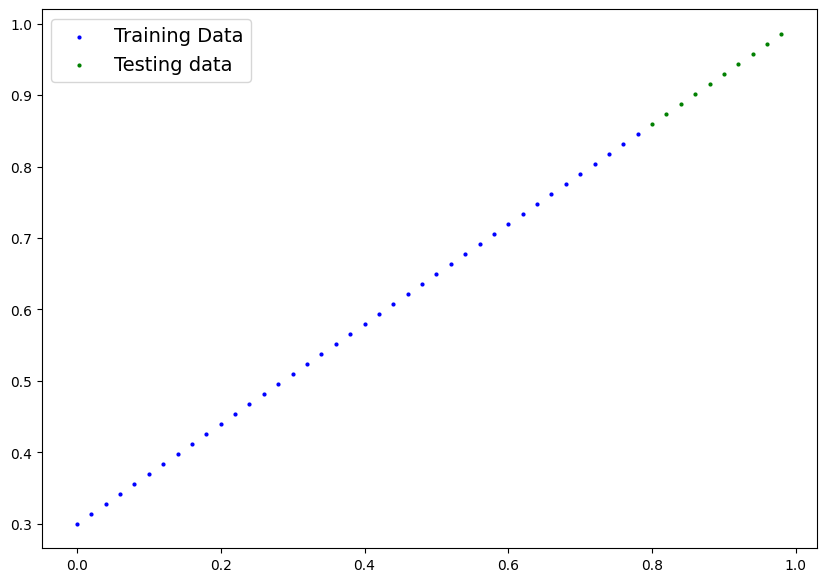

In [ ]:
plot_predictions()

## 2. Building our first PyTorch model

Our first PyTorch model

Model : Linear Regeression

We are going to use:
1. Gradient Descent algo
2. Backpropagation

Resources:
* For python OOP : https://realpython.com/python3-object-oriented-programming/
* Refer youtube 3blue1brown for algos

In [ ]:
from torch import nn

# Create a linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch extends nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
  # Forward method to define the computation in the model
  def forward(self,x: torch.Tensor):
    return self.weights * x + self.bias


### PyTorch model bulding essentials

* torch.nn - contains all of the building blocks for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - What parameters should our model try and learn, often PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it you should overwrite forward
* torch.optim - This is where the optimisers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite this methode, it defines what happens in forward computation

Resource:
* https://pytorch.org/tutorials/beginner/ptcheat.html

### Checking the contents of our PyTorch model

In [ ]:
# Create a random seed
torch.manual_seed(42)

#Create an instance of the model
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`
When we pass data through our model, it's going to run it through `forward()` method

In [ ]:
#Make prediction with model
with torch.inference_mode():
  y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

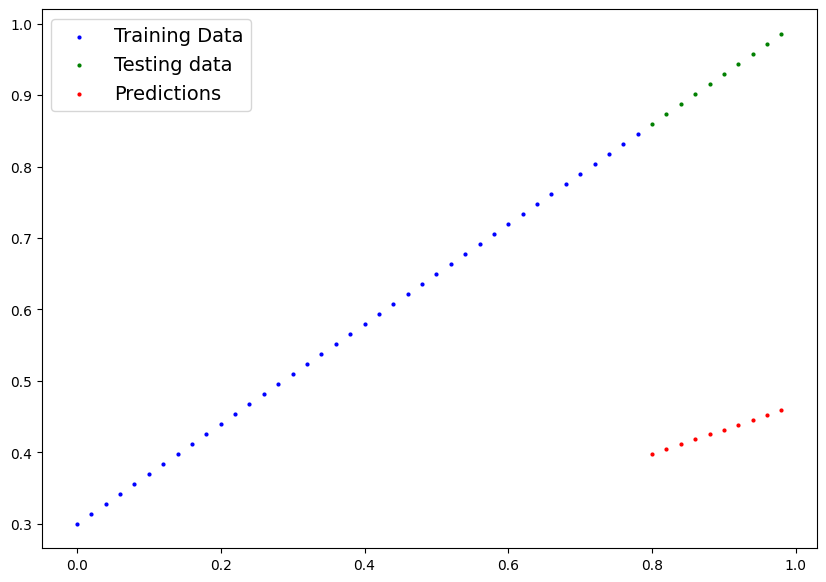

In [ ]:
plot_predictions(predictions=y_preds)

## 3. Train model

Idea is to move from unknown parameters to known parameters

To measure how poor or how wrong a model predictions are, we can make use of a loss function.

* Note: Loss function is also called cost function or criterion.

Things we need
* **Loss Function**
* **Optimiser**

Specifically for PyTorch we need
* training loop
* testing loop

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()

#Setup an optimiser (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) #lr => learning rate => important hyperparameter

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()` function)- also called forward propagation
2. Calculate loss (compare forward pass prediction with ground truth labels)
3. Optimiser zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each parameter of our model with respect to the loss (**backpropagation**)
5. Optimiser step - Use the optimiser to adjust model's parameters (**gradient descent**)

In [ ]:
torch.manual_seed(42)
# An epoch is one loop through the data...(hyperparameter)
epochs = 250

#Track different values
epoch_count = []
loss_values = []
test_loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
  #Set the model to training mode
  model_0.train() # sets all parameters that require gradients to require gradients

  # 1. Forward Pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred,y_train)
 # print("Loss:",loss)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  #5. Step the optimiser (perform gradient descent)
  optimizer.step() # by default the optimizer changes will accumulate through the loop so... we have to zero them above in step 3

  ### Testing
  model_0.eval() # turns off different settings in model not needed for rvaluation/testing (dropout/batch norm layers)
  with torch.inference_mode(): #turns off gradient tracking and a couple of more thingds
    # 1. Forward pass
    test_pred = model_0(X_test)

    # 2. Calculate loss
    test_loss = loss_fn(test_pred,y_test)
  if epoch%10==0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Epoch: 70 | Loss: 0.03476089984178543 | Test loss: 0.0805937647819519
Epoch: 80 | Loss: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch: 90 | Loss: 0.02788739837706089 | Test loss: 0.06473556160926819
Epoch: 100 | Loss: 0.024458957836031914 | Test loss: 0.05646304413676262
Epoch: 110 | Loss: 0.021020207554101944 | Test loss: 0.04819049686193466
Epoch: 120 | Loss: 0.01758546568453312 | Test loss: 0.04060482233762741
Epoch: 130 | Loss: 0.014155393466353416 | Test loss: 0.03233227878808975
Ep

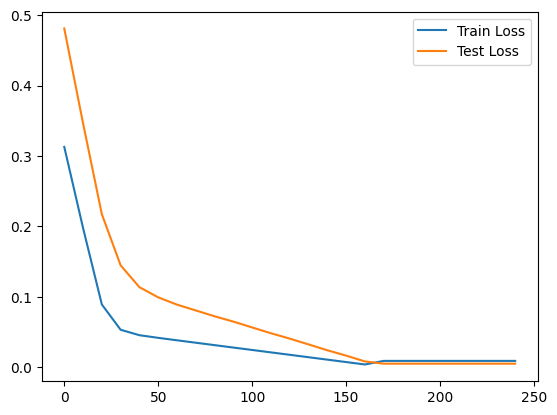

In [ ]:
# Plot loss curves
import numpy as np
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.legend()

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

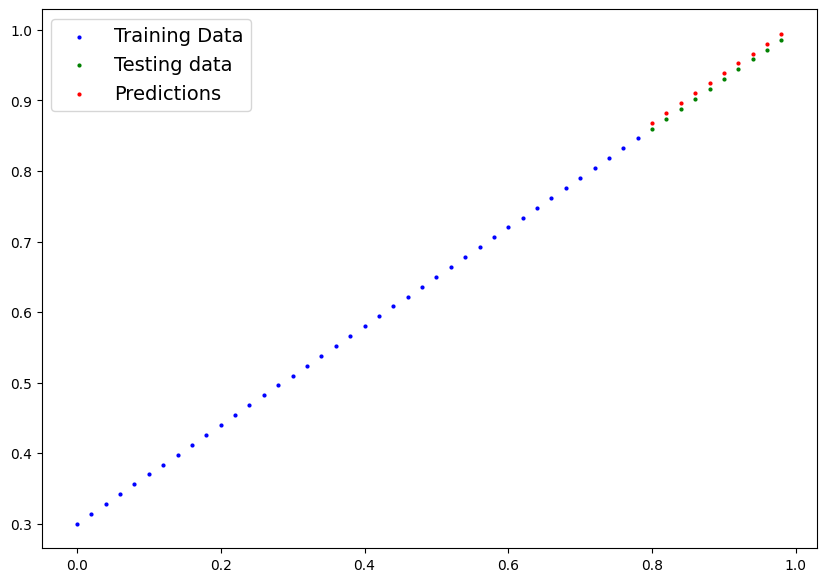

In [ ]:
plot_predictions(predictions=y_preds_new)

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

## Saving a model in PyTorch

Three main methods for saving and loading models:
1. `torch.save()` -> Saves the model in python pickle format
2. `torch.load()` -> Loads the saved model
3. `torch.nn.Module.load_state_dict()` -> load a model's saved state dictionary

In [ ]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# 2. Create model save path
MODEL_NAME = "PyTorch_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

 ## Loading a PyTorch Model

 Since we saved the model's `state_dict()` rather than the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that

In [ ]:
# To load in a saved dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

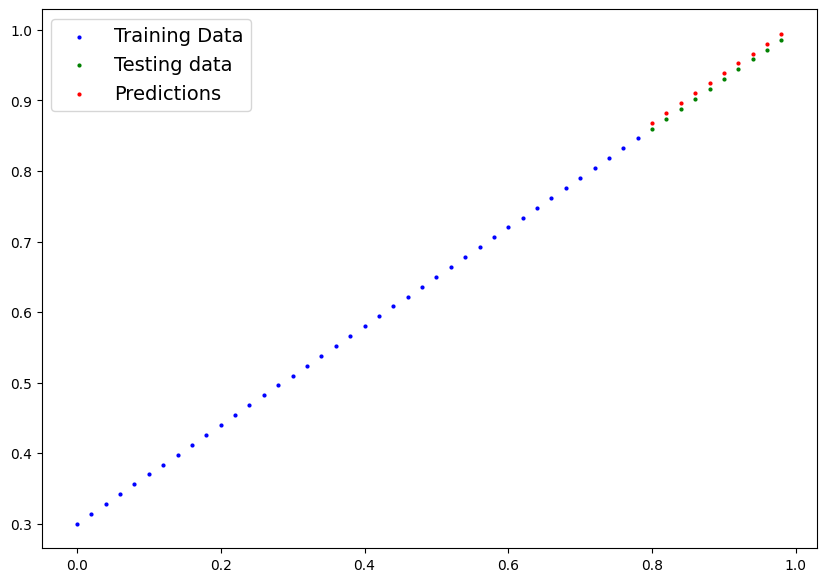

In [ ]:
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)
plot_predictions(predictions=loaded_model_preds)

## 6. Putting it all together

In [ ]:
# All the imports
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

torch.__version__

'2.0.1+cu118'

### 6.1 Device Agnostic code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### 6.2 Data

In [ ]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = X*weight+bias
X[:10],y[:10],len(X)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50)

In [ ]:
#Splitting data into train set and test set
train_split = int(0.8*len(X))
X_train = X[:train_split]
y_train = y[:train_split]
X_test = X[train_split:]
y_test = y[train_split:]

In [ ]:
def my_plot_predictions(train_data_x=X_train,
                     train_data_y=y_train,
                     test_data_x=X_test,
                     test_data_y=y_test,
                     predictions=None):
  plt.figure(figsize=(10,7))
  plt.scatter(train_data_x,train_data_y,c="b",s=4,label="Training data")
  plt.scatter(test_data_x,test_data_y,c="r",s=4,label="Testing data")
  if(predictions!=None):
    plt.scatter(test_data_x,predictions,c="g",s=4,label="Testing data")
  plt.legend(prop={"size":14})


### 6.3 Model Building

In [ ]:
class MyLinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self,x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)


In [ ]:
torch.manual_seed(42)

myModel = MyLinearRegressionModel()
myModel.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

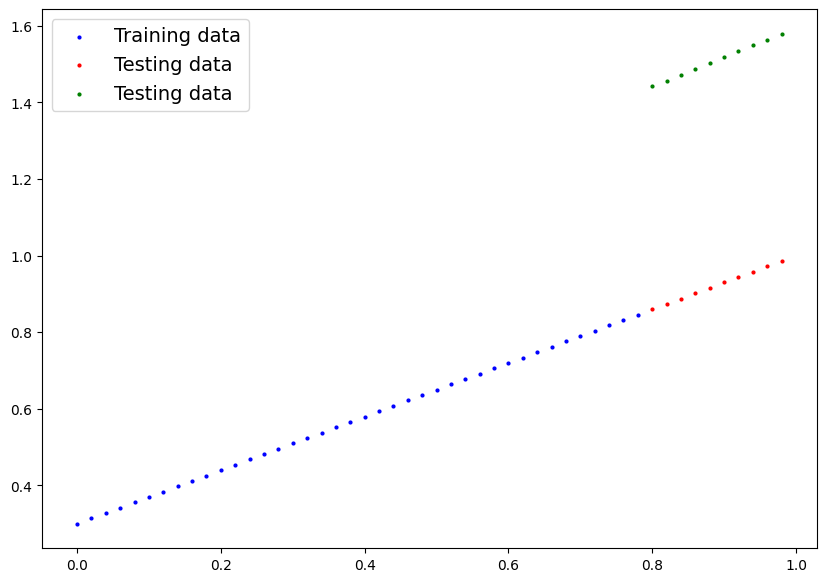

In [ ]:
with torch.inference_mode():
  y_pred = myModel(X_test)
my_plot_predictions(predictions=y_pred)

In [ ]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=myModel.parameters(),
                            lr=0.01)

In [ ]:
#Training loop
def Training_Loop(X_train,X_test,y_train,y_test,epochs):
  torch.manual_seed(42)
  epoch_count = []
  loss_values = []
  test_loss_values = []

  for epoch in range(epochs):
    myModel.train()

    y_pred = myModel(X_train)

    loss = loss_fn(y_pred,y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    myModel.eval()

    with torch.inference_mode():
      test_pred = myModel(X_test)

      test_loss = loss_fn(test_pred,y_test)

    if epoch%10==0:
      epoch_count.append(epoch)
      loss_values.append(loss)
      test_loss_values.append(test_loss)
      print(f"Epoch = {epoch} | Loss = {loss} | test-loss = {test_loss}")

  return epoch_count,np.array(torch.tensor(loss_values).numpy()),test_loss_values

In [ ]:
epochs,loss,test_loss = Training_Loop(X_train,X_test,y_train,y_test,200)

Epoch = 0 | Loss = 0.5551779866218567 | test-loss = 0.5739762187004089
Epoch = 10 | Loss = 0.4399680495262146 | test-loss = 0.4392663538455963
Epoch = 20 | Loss = 0.3247582018375397 | test-loss = 0.30455657839775085
Epoch = 30 | Loss = 0.20954827964305878 | test-loss = 0.16984674334526062
Epoch = 40 | Loss = 0.09433844685554504 | test-loss = 0.03513689711689949
Epoch = 50 | Loss = 0.023886386305093765 | test-loss = 0.04784906655550003
Epoch = 60 | Loss = 0.0199567973613739 | test-loss = 0.04580312222242355
Epoch = 70 | Loss = 0.016517987474799156 | test-loss = 0.0375305712223053
Epoch = 80 | Loss = 0.013089170679450035 | test-loss = 0.029944902285933495
Epoch = 90 | Loss = 0.009653178043663502 | test-loss = 0.02167237363755703
Epoch = 100 | Loss = 0.006215679459273815 | test-loss = 0.014086711220443249
Epoch = 110 | Loss = 0.002787243574857712 | test-loss = 0.005814164876937866
Epoch = 120 | Loss = 0.0012645035749301314 | test-loss = 0.013801807537674904
Epoch = 130 | Loss = 0.00126450

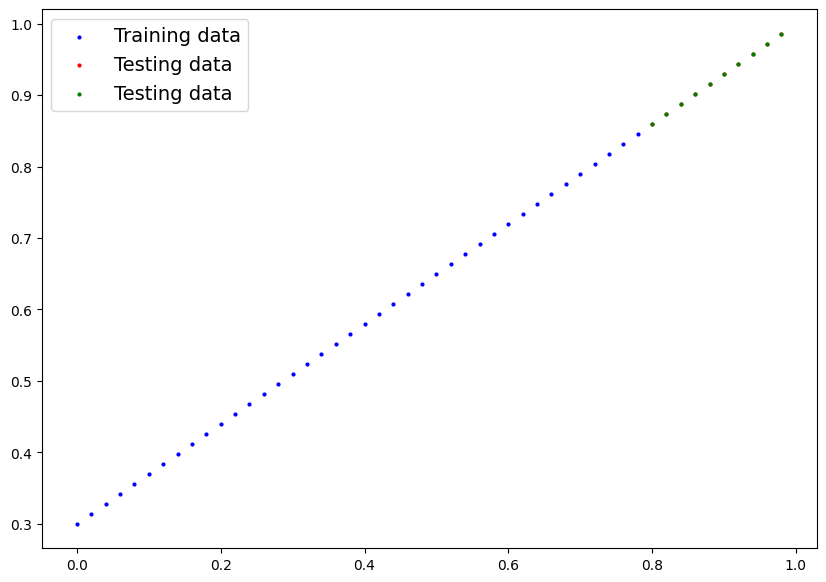

In [ ]:
with torch.inference_mode():
  y_pred = myModel(X_test)
my_plot_predictions(predictions=y_pred)

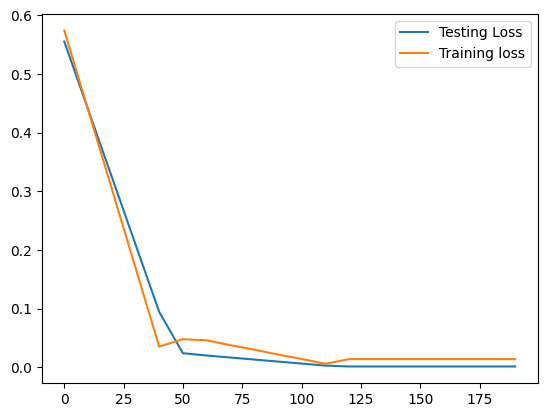

In [ ]:
plt.plot(epochs,loss,label="Testing Loss")
plt.plot(epochs,test_loss,label="Training loss")
plt.legend()

### 6.4 Saving and loading the model

In [ ]:
from pathlib import Path

MODEL_PATH = Path("models")

MODEL_PATH_NAME = MODEL_PATH / "PyTorch2_2.pth"

torch.save(obj=myModel.state_dict(),
           f = MODEL_PATH_NAME)

In [ ]:
newModel = MyLinearRegressionModel()
newModel.load_state_dict(torch.load(f=MODEL_PATH_NAME))
newModel.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])